In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from astropy.io import fits

import scipy.stats as stats
from scipy.signal import find_peaks

In [10]:
def median_frames(folder, filenames, shape=(2048, 2048)):

    cube = np.zeros((len(filenames), shape[0], shape[1]))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        cube[i, :, :] = hdul[0].data
        hdul.close()

    cube_med = np.median(cube, axis=0)

    return cube_med

### Housekeeping

In [5]:
folder = '/Users/isabelkain/Downloads/UGC11876'
filelist = glob.glob(f'{folder}/*.fits')

## Generate list of filenames

fnames = np.array([])
fpaths = np.array([])

for f in filelist:
    txt = f.split('/')[-1].split('.')[0]  # reduce full path to just file name (w/out extension)
    fnames = np.append(fnames, txt)
    fpaths = np.append(fpaths, f[:-11])

## List of filetypes (e.g. bias, flat, science, etc)

ftypes = np.array([])

for f in filelist:

    hdul = fits.open(f)
    tag = hdul[0].header['OBJECT']
    hdul.close()

    ftypes = np.append(ftypes, tag)

## Zip filenames and types into pandas DF

filedict = pd.DataFrame(np.array([fpaths, fnames, ftypes]).T, columns=['Path', 'Filename', 'Target'])
filedict.sort_values(by='Filename', inplace=True, ignore_index=True)
filedict

,Path,Filename,Target
0,/Users/isabelkain/Downloads/UGC11876,r1050,ArcFlat
1,/Users/isabelkain/Downloads/UGC11876,r1051,ArcFlat
2,/Users/isabelkain/Downloads/UGC11876,r1052,ArcFlat
3,/Users/isabelkain/Downloads/UGC11876,r1053,ArcFlat
4,/Users/isabelkain/Downloads/UGC11876,r1054,ArcFlat
5,/Users/isabelkain/Downloads/UGC11876,r1055,DomeFlat
6,/Users/isabelkain/Downloads/UGC11876,r1056,DomeFlat
7,/Users/isabelkain/Downloads/UGC11876,r1057,DomeFlat
8,/Users/isabelkain/Downloads/UGC11876,r1058,DomeFlat
9,/Users/isabelkain/Downloads/UGC11876,r1059,DomeFlat


In [6]:
sci_ix = (filedict['Target']=='Science')
bias_ix = (filedict['Target']=='Bias')
flat_ix = (filedict['Target']=='DomeFlat')
arc_ix = (filedict['Target']=='ArcFlat')

###  Pixel calibration

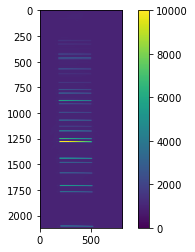

In [17]:
fnames = filedict[arc_ix]['Filename'].array
fpaths = filedict[arc_ix]['Path'].array

arc_img = median_frames(fpaths[0], fnames, shape=(2120,800))

plt.imshow(arc_img, vmin=0, vmax=10000)
plt.colorbar()

(0.0, 2130.0)

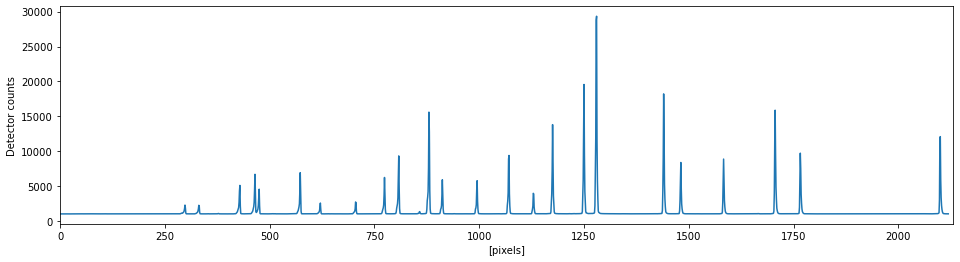

In [25]:
arc_spectrum = arc_img[:, 300]

plt.figure(figsize=(16,4))
plt.plot(arc_spectrum)

plt.ylabel('Detector counts')
plt.xlabel('[pixels]')
plt.xlim(0, len(arc_spectrum)+10)

(0.0, 2130.0)

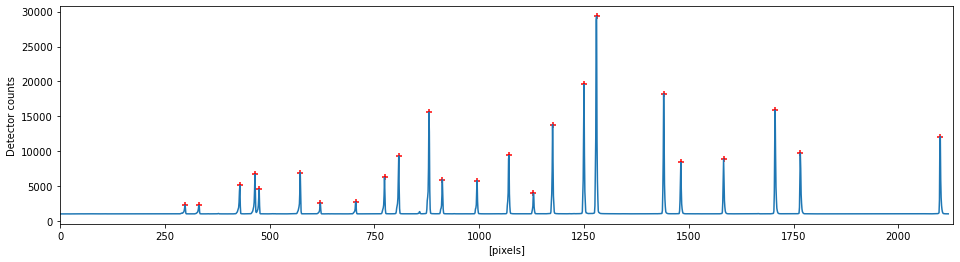

In [42]:
peak_indices, __ = find_peaks(arc_spectrum, prominence=80, height=2000)

plt.figure(figsize=(16,4))
plt.plot(arc_spectrum)
plt.scatter(peak_indices, arc_spectrum[peak_indices], marker='+', color='r')

plt.ylabel('Detector counts')
plt.xlabel('[pixels]')
plt.xlim(0, len(arc_spectrum)+10)

In [43]:
len(peak_indices)

24

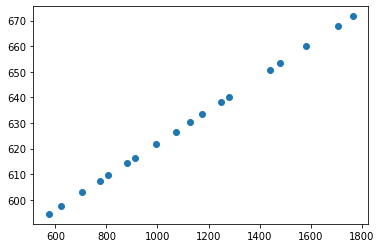

In [46]:
wvl = {'h':594.483,
       'i':597.528,
       'j':603.000,
       'k':607.434,
       'l':609.616,
       'm':614.306,
       'n':616.359,
       'o':621.728,
       'p':626.650,
       'q':630.479,
       'r':633.440,
       's':638.299,
       't':640.225,
       'u':650.653,
       'v':653.288,
       'w':659.895,
       'x':667.820,
       'y':671.704,
#        'a':340.365,
#        'b':346.655,
#        'c':361.051,
#        'd':365.015,
#        'e':366.288,
        }

a = peak_indices[0]
b = peak_indices[1]
c = peak_indices[2]
d = peak_indices[3]
e = peak_indices[4]
h = peak_indices[5]
i = peak_indices[6]
j = peak_indices[7]
k = peak_indices[8]
l = peak_indices[9]
m = peak_indices[10]
n = peak_indices[11]
o = peak_indices[12]
p = peak_indices[13]
q = peak_indices[14]
r = peak_indices[15]
s = peak_indices[16]
t = peak_indices[17]
u = peak_indices[18]
v = peak_indices[19]
w = peak_indices[20]
x = peak_indices[21]
y = peak_indices[22]
# z = ??? not on lamp calibration plot

indices = np.array([h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y])
wvl_vals = np.array(list(wvl.values()))


plt.scatter(indices, wvl_vals)

[3.93714224e-08 6.47079227e-02 5.57340451e+02]


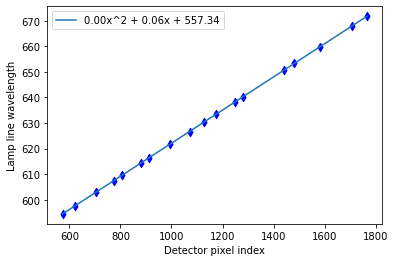

In [47]:
## Fit curve to px/nm plot

p = np.polyfit(indices, wvl_vals, 2)
x = np.linspace(np.min(indices), np.max(indices), len(indices))

print(p)

plt.plot(x, p[0]*x**2 + p[1]*x + p[2], label=f'{p[0]:0.2f}x^2 + {p[1]:0.2f}x + {p[2]:0.2f}')
plt.scatter(indices, wvl.values(), marker='d', color='b')
plt.xlabel('Detector pixel index')
plt.ylabel('Lamp line wavelength')

plt.legend()

In [49]:
## Apply pixel solution, create wavelength axis

pxl_axis = np.arange(0,len(arc_spectrum))
wavelengths = p[0]*pxl_axis**2 + p[1]*pxl_axis + p[2]

print(wavelengths[0], wavelengths[-1])
wavelengths

557.3404511322955 694.6333233791331


array([557.34045113, 557.40515909, 557.46986714, ..., 694.50357398,
       694.56844864, 694.63332338])

Text(0.5, 1.0, 'Arc lamp spectrum\nNeon, Hg-Ar, He')

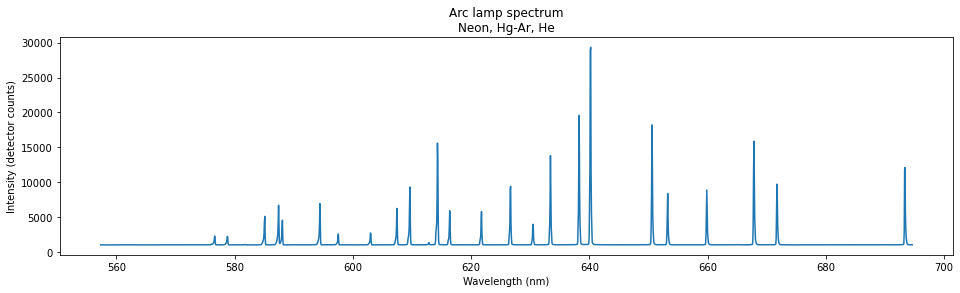

In [50]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths, arc_spectrum)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (detector counts)')
plt.title('Arc lamp spectrum\nNeon, Hg-Ar, He')

### Flat & bias calibration